# Use edge coloring to reduce the depth of quantum circuits

This guide will show how to use the [qiskit_addon_utils.coloring](https://qiskit.github.io/qiskit-addon-utils/apidocs/qiskit_addon_utils.coloring.html) module to color edges of a coupling map and use the coloring to more efficiently place gates in a quantum circuit, leading to shallower circuits.

The point of edge-coloring a graph is to find a set of edge colors such that no two edges of the same color share a common node. For a quantum processor, this means that gates along like-colored edges (qubit connections) may be run simultaneously and that the circuit will execute faster. We can use this to define our circuit in a way that is more amenable to the hardware it should run on.

First, we will specify a backend and visualize its qubit topology.

In [1]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()
coupling_map = backend.coupling_map

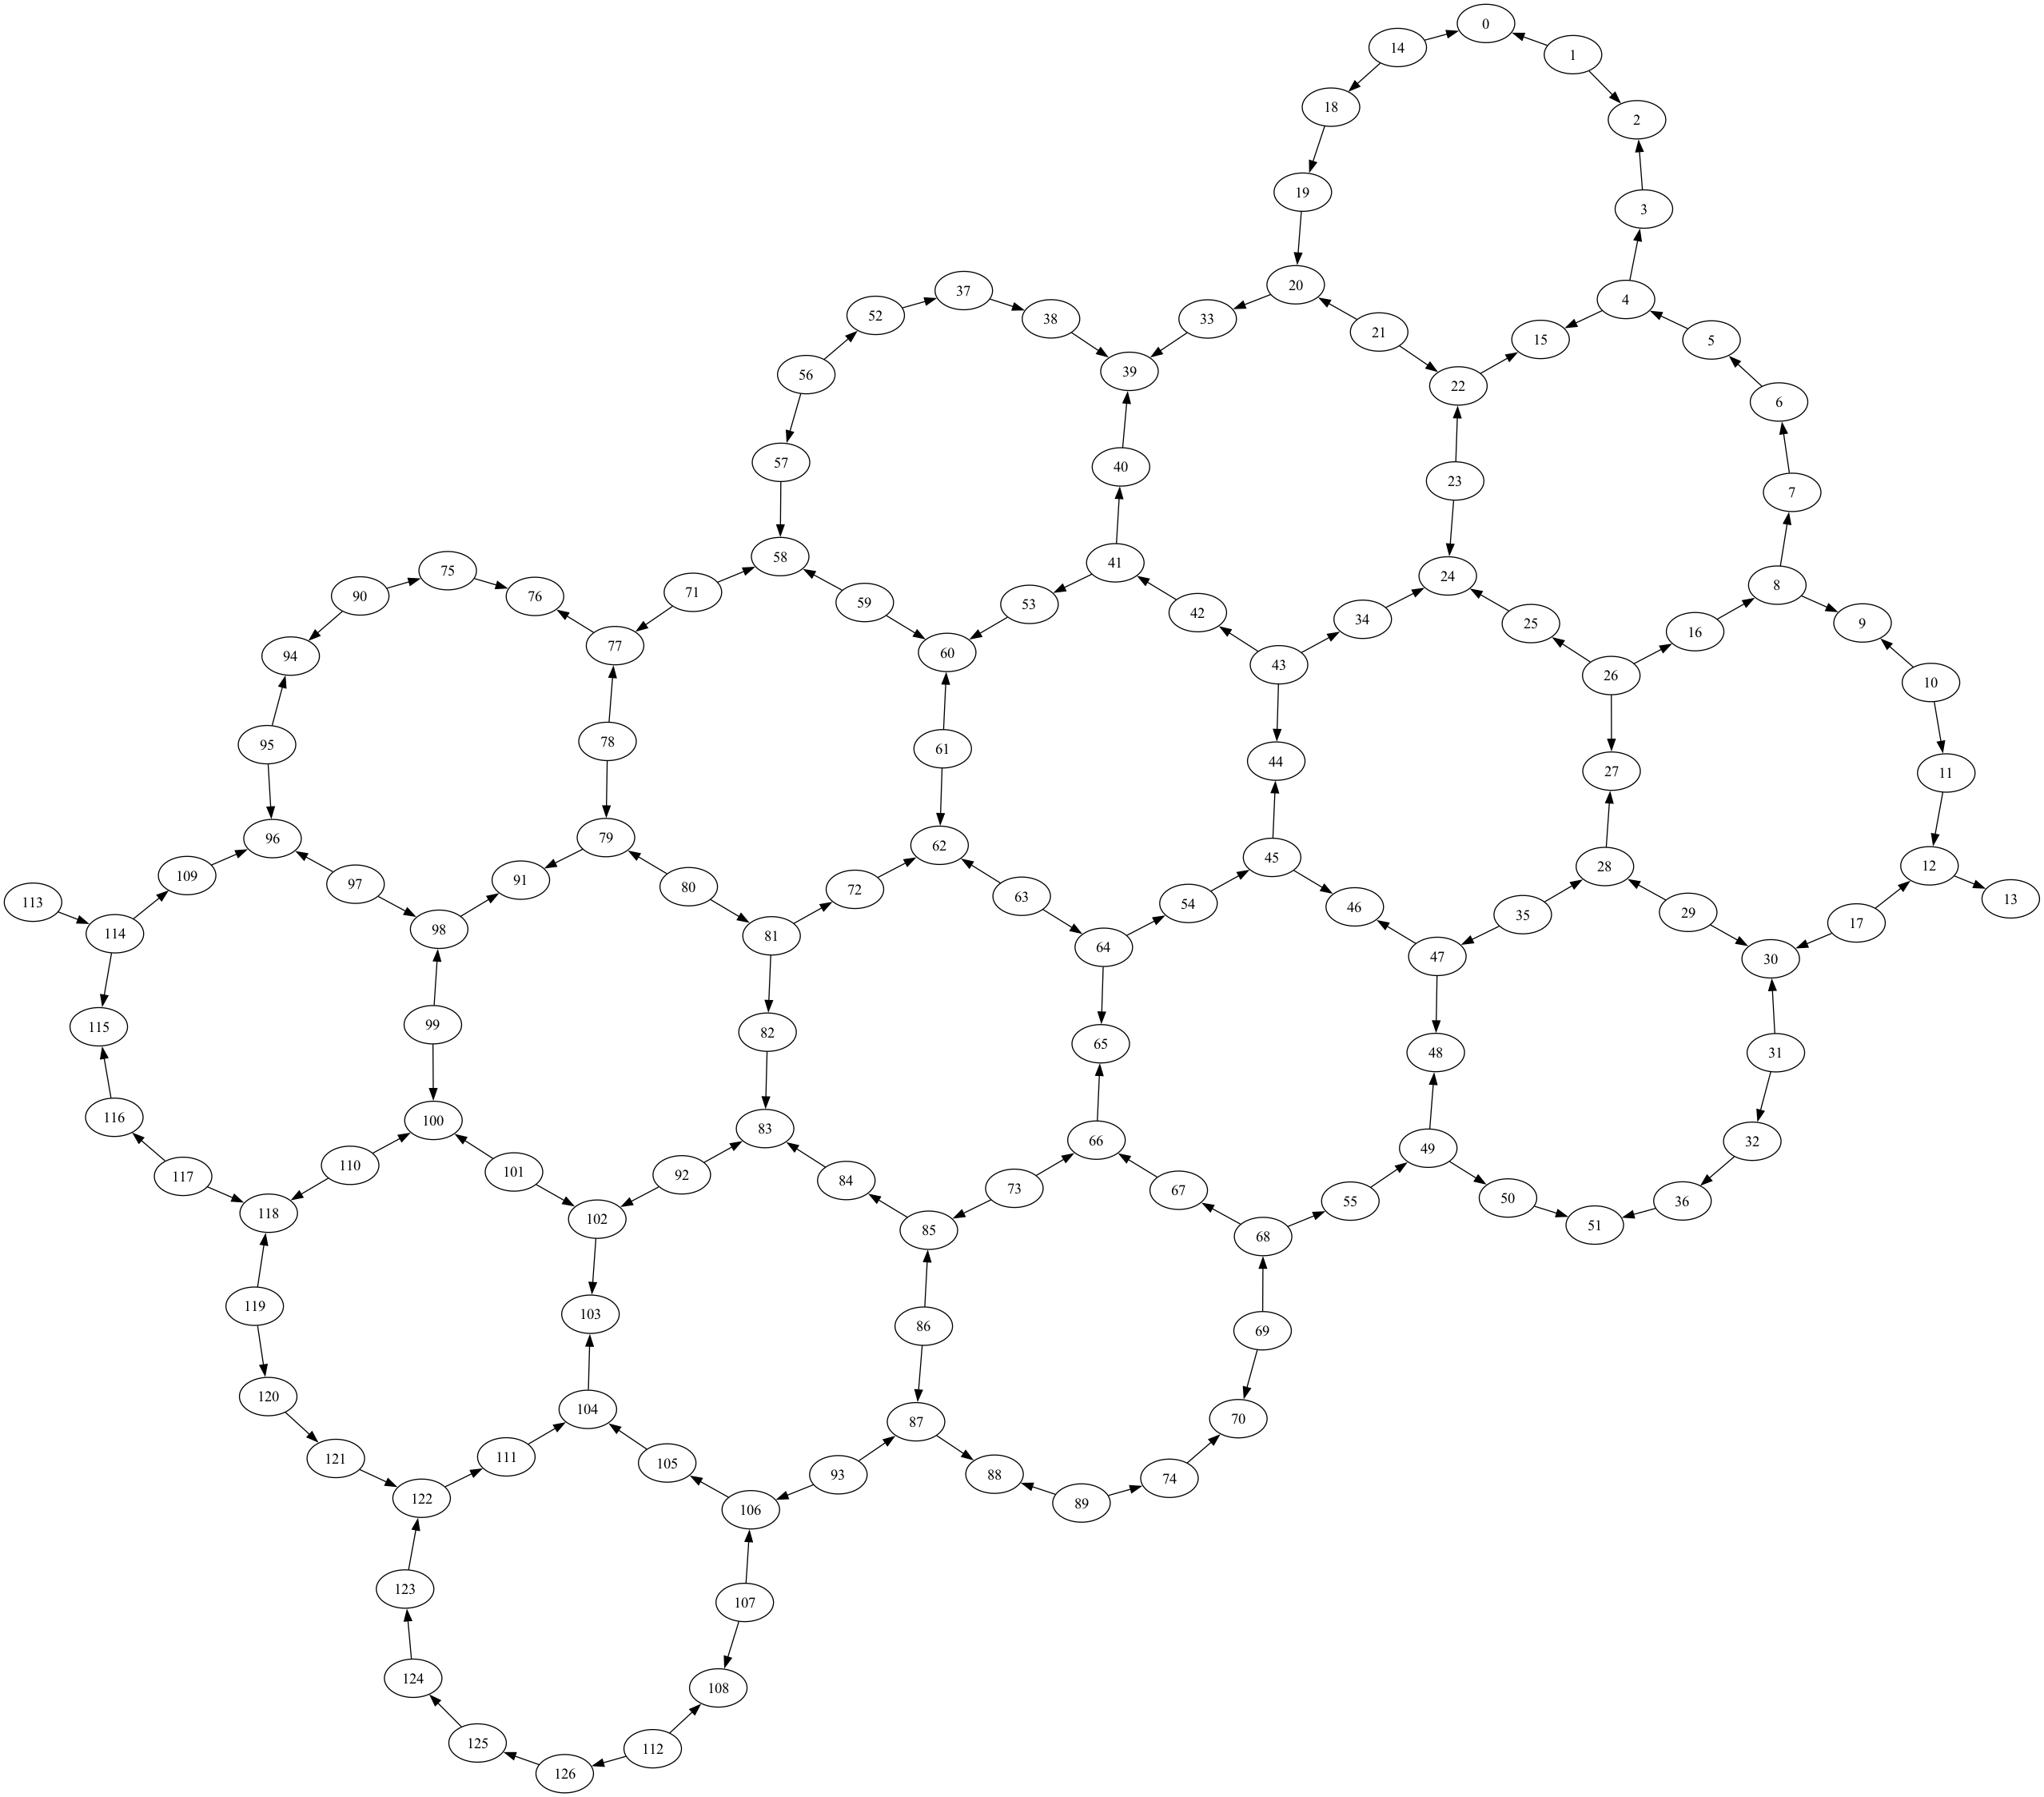

In [2]:
from rustworkx.visualization import graphviz_draw

graphviz_draw(coupling_map.graph, method="neato")

Next we use the [qiskit_addon_utils.coloring.auto_color_edges](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.coloring.auto_color_edges.html#qiskit_addon_utils.coloring.auto_color_edges) function to generate an edge coloring. This is a light wrapper for [rustworkx.graph_greedy_edge_color](https://www.rustworkx.org/dev/apiref/rustworkx.graph_greedy_edge_color.html) that does some minor post-processing of the output. Namely, this function removes an arbitrary edge direction if an edge is bi-directional and combines the edge and color information into a dictionary format.

In [3]:
from qiskit_addon_utils.coloring import auto_color_edges
from rustworkx import PyDiGraph

coloring = auto_color_edges(coupling_map)

# Create a colored graph for visualization
eagle_r3 = PyDiGraph()
eagle_r3.extend_from_weighted_edge_list(
    [(source, target, color) for ((source, target), color) in coloring.items()]
)
print(f"There are {len(coloring)} edges and {len(set(coloring.values()))} unique colors.")
print(
    f'The edges are specified by length-2 tuples: (e.g. {next(iter(coloring))}).\
    \nThe "colors" are actually specified by a set of integers: {set(coloring.values())}'
)

There are 144 edges and 3 unique colors.
The edges are specified by length-2 tuples: (e.g. (1, 0)).    
The "colors" are actually specified by a set of integers: {0, 1, 2}


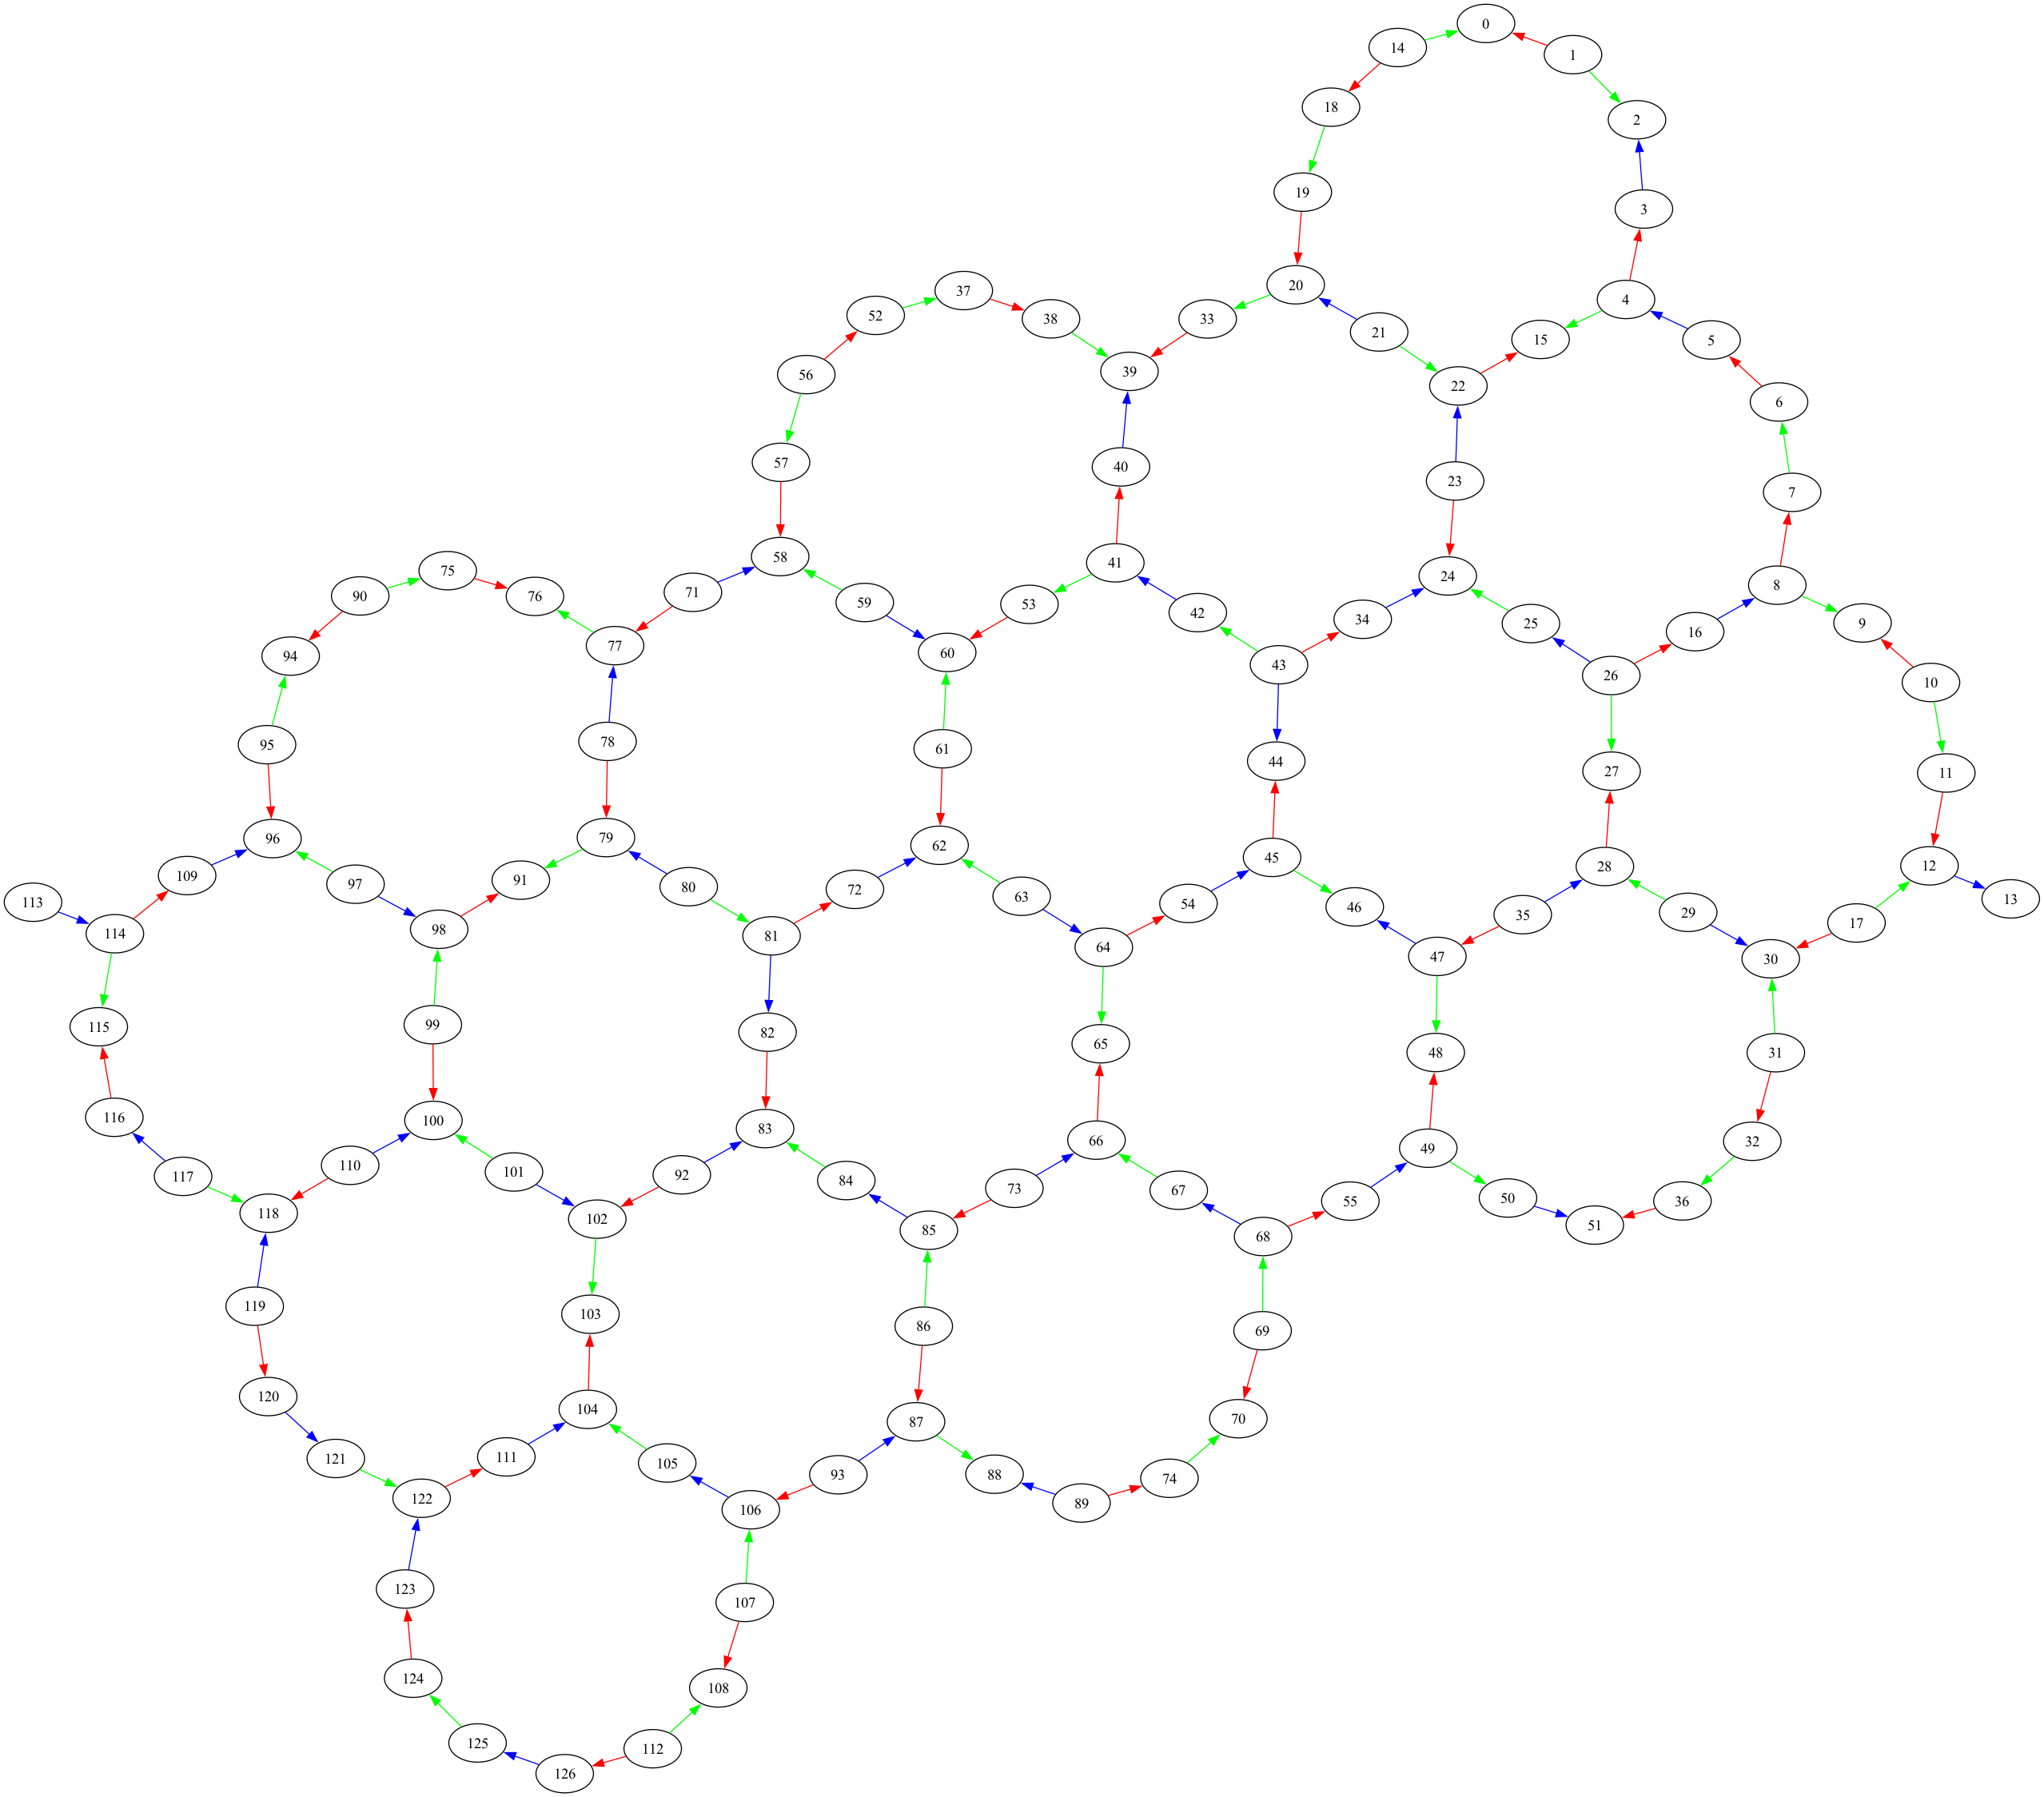

In [4]:
def color_edge_3color(edge):
    """Return the color of an edge."""
    # Map integers of a 3-coloring to color names
    color_dict = {0: "red", 1: "green", 2: "blue"}
    return {"color": color_dict[edge]}


graphviz_draw(eagle_r3, edge_attr_fn=color_edge_3color, method="neato")

Next, let's make a circuit with a ``CZGate`` on each edge and observe its depth. For this first circuit, we will just naively place a gate on each edge. We will place barriers in ``depth-1`` increments to illustrate how crucial edge-coloring is when designing a hardware-efficient quantum circuit.

The circuit has depth: 37


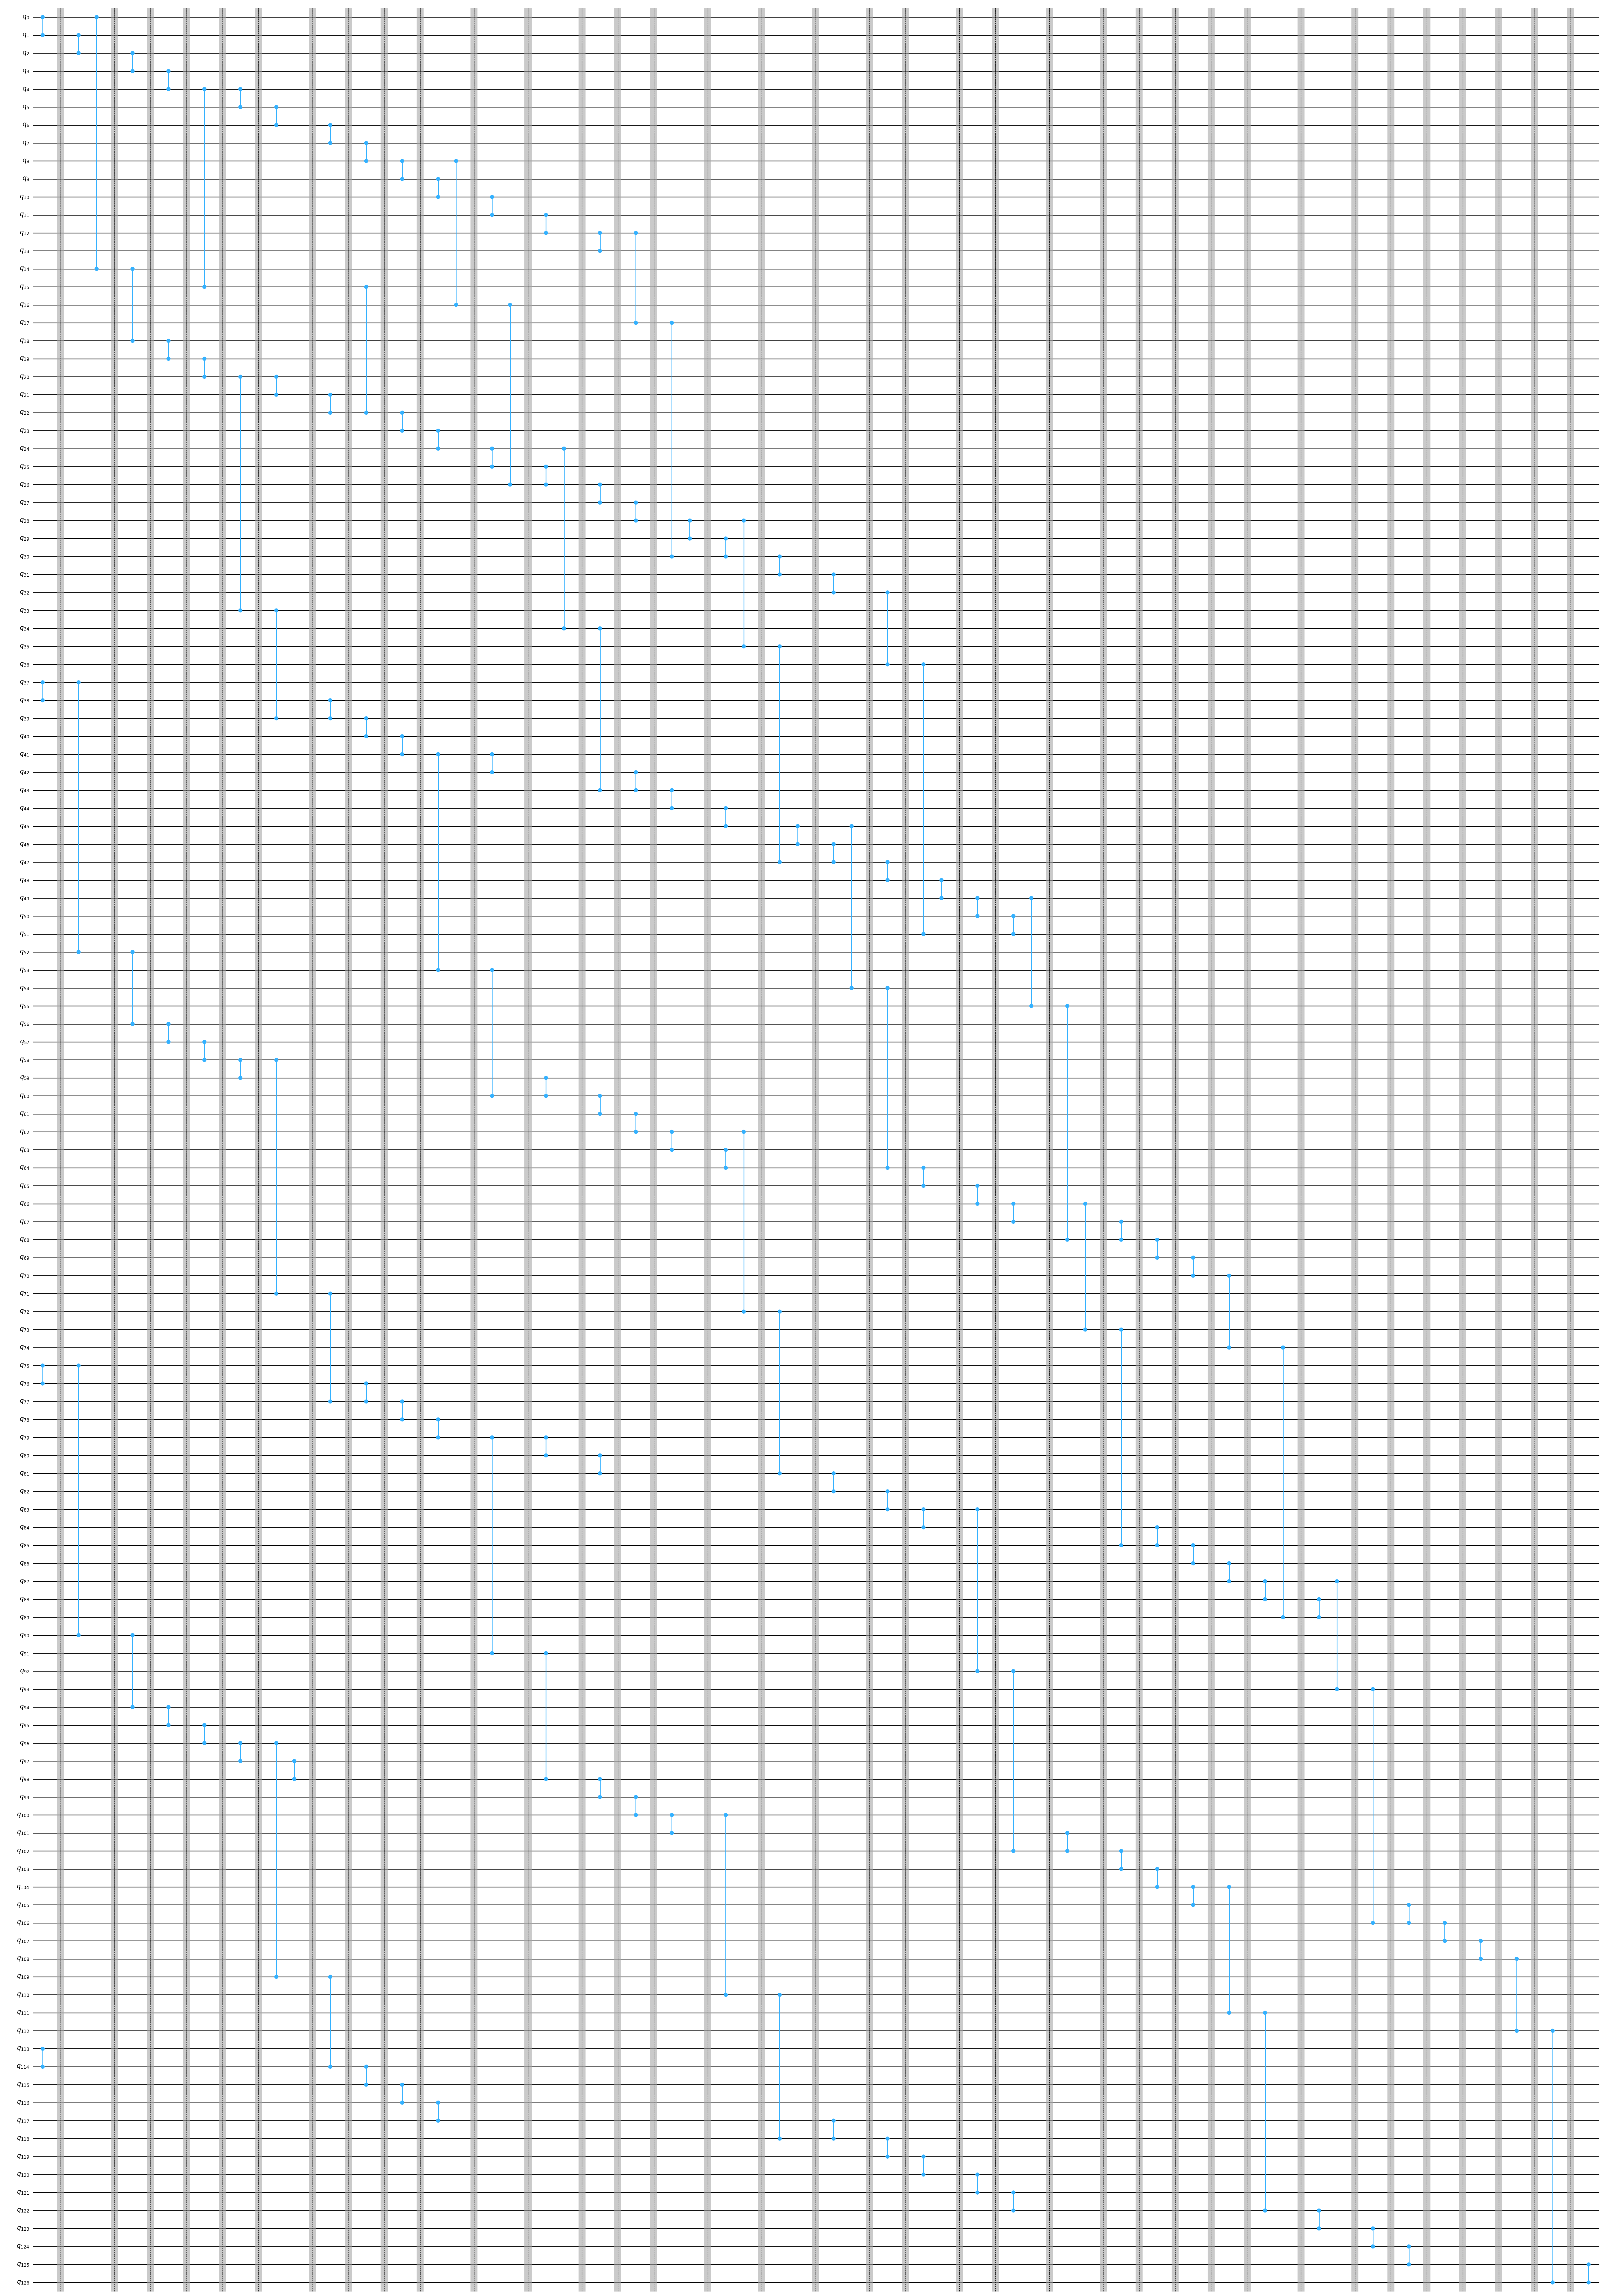

In [5]:
from qiskit import QuantumCircuit
from qiskit_addon_utils.slicing import combine_slices, slice_by_depth

circuit = QuantumCircuit(backend.num_qubits)
for edge in coupling_map.graph.edge_list():
    circuit.cz(edge[0], edge[1])
print(f"The circuit has depth: {circuit.depth()}")

# Add barriers in depth-1 increments
slices = slice_by_depth(circuit, max_slice_depth=1)
circuit = combine_slices(slices, include_barriers=True)

circuit.draw("mpl", fold=-1)

Now let's place all of the gates of a given color at the same time. We can see the depth is reduced from ``37`` to ``3``. This is because we can take advantage of the fact that all gates on a given color can run at the same time.

The circuit has depth: 3


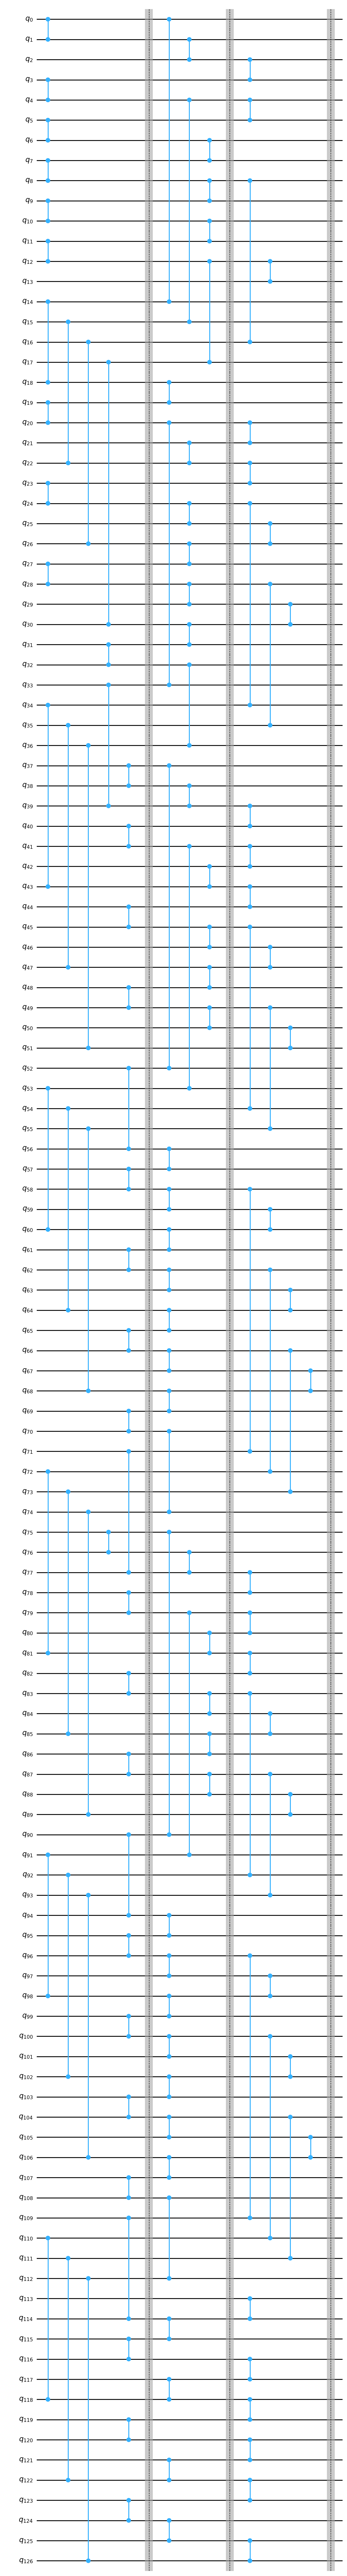

In [6]:
from collections import defaultdict

circuit = QuantumCircuit(backend.num_qubits)

# Make a reverse coloring dict
color_to_edge = defaultdict(list)
for edge, color in coloring.items():
    color_to_edge[color].append(edge)

# Place edges in order of color
for edges in color_to_edge.values():
    for edge in edges:
        circuit.cz(edge[0], edge[1])
    circuit.barrier()
print(f"The circuit has depth: {circuit.depth(lambda x: x.name != "barrier")}")
circuit.draw("mpl", fold=-1)